## Using the model created in the other notebook to make our project

### Importing the libraries

In [7]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

### Loading the object detection model and the face mask detection model

In [13]:
# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
weights = 'yolov4-tiny.weights'
config = 'yolov4-tiny.cfg'
net = cv2.dnn.readNet(weights, config)
face_detect = cv2.dnn_DetectionModel(net)
face_detect.setInputParams(size=(224, 224), scale=1/255)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
face_mask_model = 'mask_detector.model'
model = load_model(face_mask_model)

[INFO] loading face detector model...
[INFO] loading face mask detector model...


In [14]:
def detect_people(img):
    results = []
    (class_ids, scores, bboxes) = face_detect.detect(img)
    indices = cv2.dnn.NMSBoxes(bboxes, scores, 0.3, 0.5)
    for index in indices:
        # we only want to detect people
        if class_ids[index] == 0:
            (x, y, w, h) = bboxes[index]
            center_x = x + (w // 2)
            center_y = y + (h // 2)
            r = (scores[index], (x, y, x+w, y+h))
            results.append(r)
    return results

In [25]:
def detect_mask(image):
    # detect the people in the image
    results = detect_people(image)
    # loop over the detections
    for r in results:
        (score, (startX, startY, endX, endY)) = r 
        if score > 0.5:
            # extract the face ROI, convert it from BGR to RGB channel ordering, resize it to 224x224, and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            # pass the face through the model to determine if the face has a mask or not
            (mask, withoutMask) = model.predict(face, verbose = 0)[0]
            # determine the class label and color we'll use to draw the bounding box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
            # display the label and bounding box rectangle on the output frame
            cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
            return image

### Trying our model on images

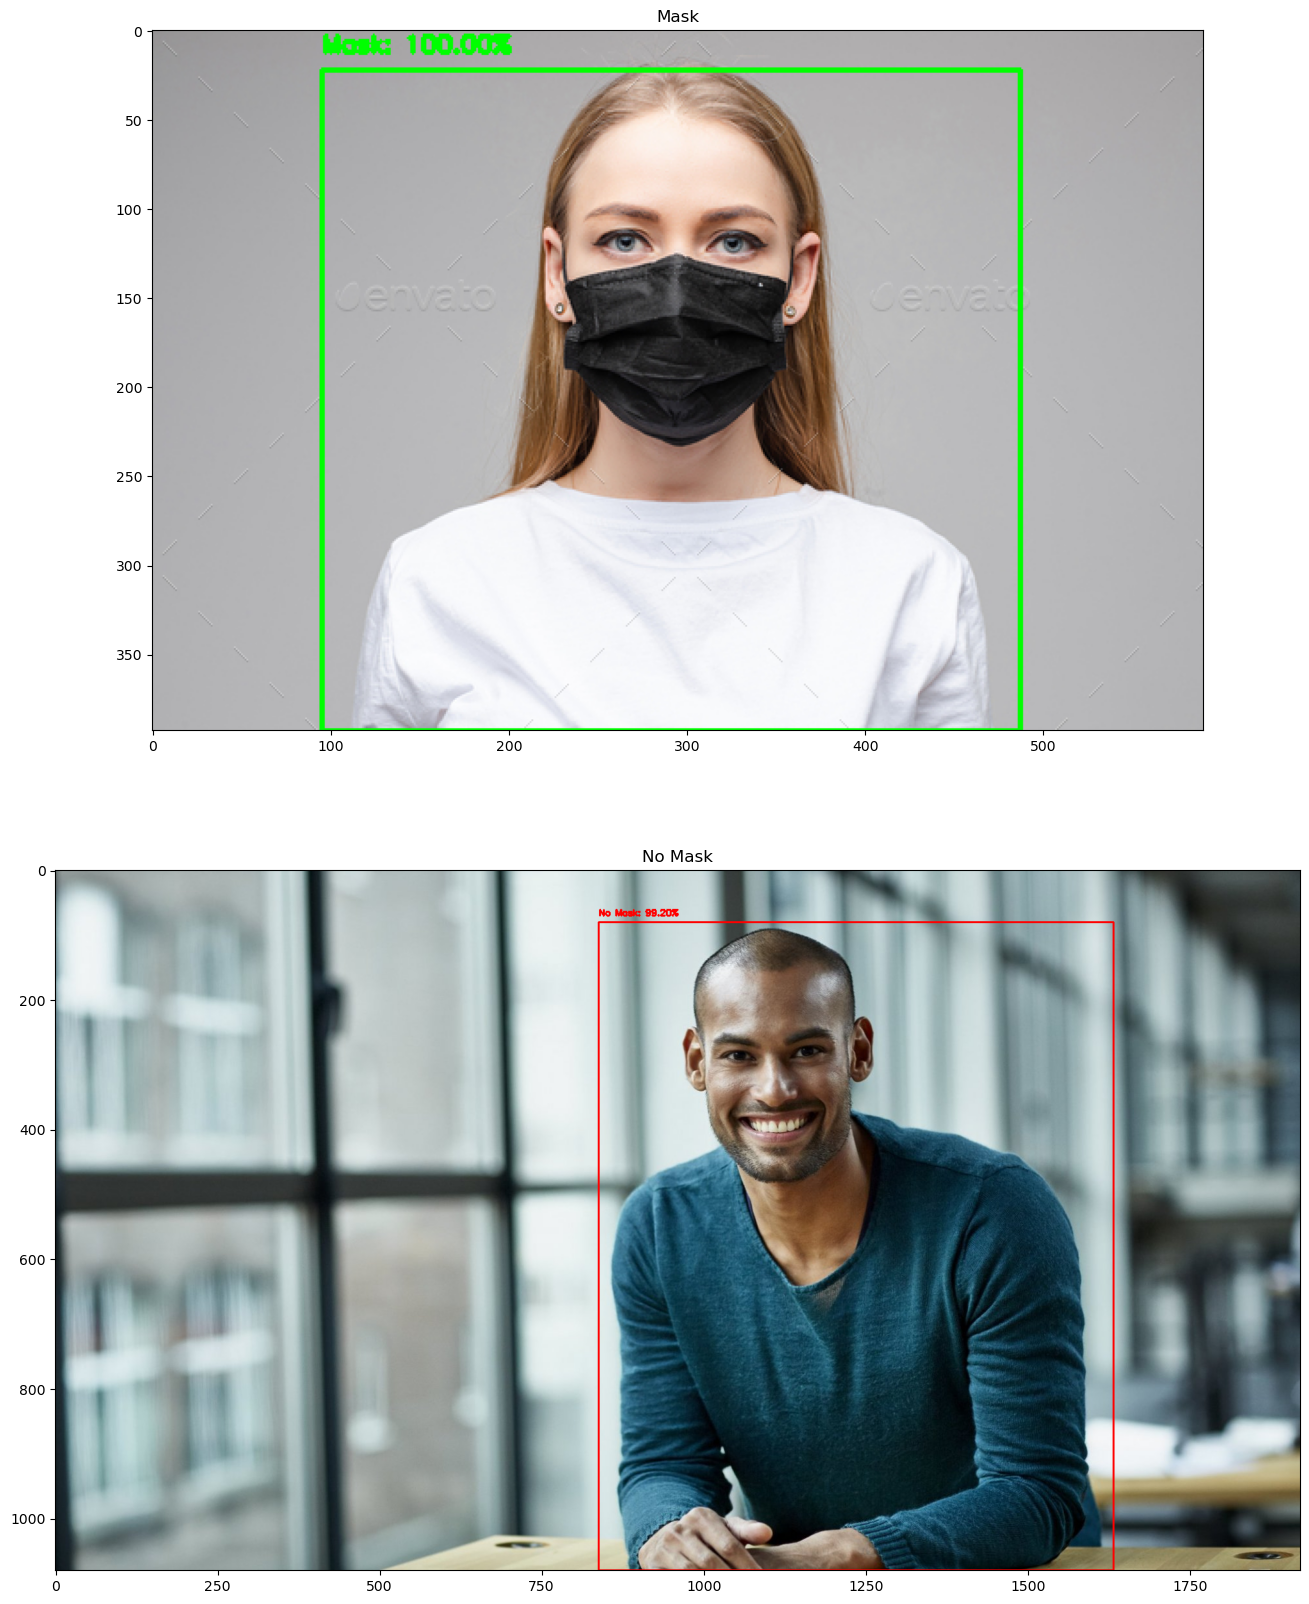

In [26]:
mask = cv2.imread(os.path.join('dataset', 'mask.jpg'))
mask = detect_mask(mask)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
no_mask = cv2.imread(os.path.join('dataset', 'no_mask.jpg'))
no_mask = detect_mask(no_mask)
no_mask = cv2.cvtColor(no_mask, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.title('Mask')
plt.imshow(mask);
plt.subplot(2, 1, 2)
plt.title('No Mask')
plt.imshow(no_mask);

### Now lets go to the fun part, live detection !

In [51]:
# initialize the camera
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1288)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
while True:
    # getting frames
    ret, frame = cap.read()    
    # object detection
    detect_mask(frame)
    cv2.imshow("Frame" ,frame)
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 36ms/step
